In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
!pip show yfinance

Name: yfinance
Version: 0.2.54
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: beautifulsoup4, frozendict, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


In [3]:
# Choose stock name and date range
ticker = "AZN.L"  # AstraZeneca on the London Stock Exchange
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # 1 year of data

In [4]:
# Download data
data = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
print(data.columns)

MultiIndex([( 'Close', 'AZN.L'),
            (  'High', 'AZN.L'),
            (   'Low', 'AZN.L'),
            (  'Open', 'AZN.L'),
            ('Volume', 'AZN.L')],
           names=['Price', 'Ticker'])


In [6]:
# Calculate daily log returns
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

In [7]:
# Calculate annualised volatility (historical volatility)
volatility = data['LogReturn'].std() * np.sqrt(252)

In [8]:
# Get the latest adjusted closing price
spot_price = data['Close'].iloc[-1]

In [9]:
# Print results
print("Spot Price (S):", round(spot_price, 2))
print("Annualised Volatility (σ):", round(volatility, 4))

Spot Price (S): Ticker
AZN.L    9680.0
Name: 2025-04-09 00:00:00, dtype: float64
Annualised Volatility (σ): 0.2446


In [10]:
def euro_option_bsm(S, K, T, r, vol, payoff):
    
    #S: stock price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) #BSM for call option
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) #BSM for put option
    
    return option_value

In [11]:
euro_option_bsm(10054, 10200, 0.5, 0.045, 0.2334, 'call')

699.8092136398654

In [12]:
# Spot price range (higher resolution)
S = np.linspace(9500, 11000, 100)

In [13]:
# Constants
K = 10200
T = 0.5
r = 0.045
vol = 0.2334

In [14]:
# Compute option prices and payoff
option_price = [euro_option_bsm(s, K, T, r, vol, "call") for s in S]
payoff = [max(s - K, 0) for s in S]

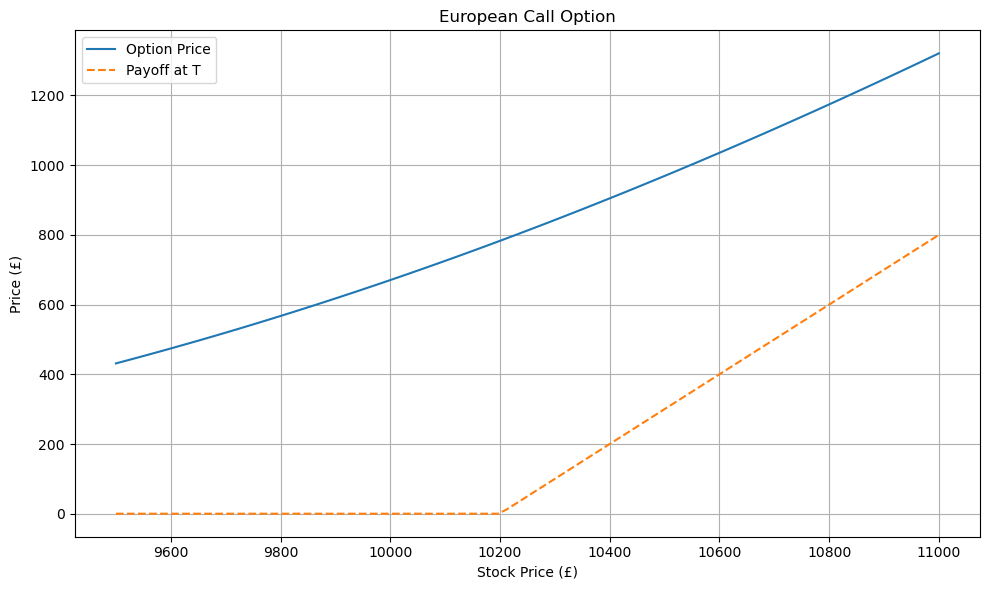

In [15]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(S, option_price, label='Option Price')
plt.plot(S, payoff, '--', label='Payoff at T')
plt.title('European Call Option')
plt.xlabel('Stock Price (£)')
plt.ylabel('Price (£)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Parameters 
S = 10054          # Spot price
K = 10200          # Strike price
T = 0.5            # Time to maturity in years
r = 0.045          # Risk-free interest rate
sigma = 0.2334     # Volatility (you can use historical or implied)
N = 100            # Number of steps in the binomial tree


In [17]:
#Binomial model
# Calculate time step and up/down factors
dt = T / N
u = np.exp(sigma * np.sqrt(dt))      # Up factor
d = 1 / u                            # Down factor
p = (np.exp(r * dt) - d) / (u - d)   # Risk-neutral probability

In [18]:
# Create asset price tree
stock_tree = np.zeros((N + 1, N + 1))
for i in range(N + 1):
    for j in range(i + 1):
        stock_tree[j, i] = S * (u ** (i - j)) * (d ** j)

In [19]:
# Create option value tree
option_tree = np.zeros((N + 1, N + 1))
for j in range(N + 1):
    option_tree[j, N] = max(stock_tree[j, N] - K, 0)  # Payoff at maturity

In [20]:
# Backward induction
for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        option_tree[j, i] = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])

In [21]:
# Final result at the root node
binomial_price = option_tree[0, 0]
print("Binomial Tree European Call Price: £", round(binomial_price, 2))

Binomial Tree European Call Price: £ 701.35


In [22]:
#redefining the function with the full logic inside so I can use it for the Convergence Plot
def binomial_price_func(S, K, T, r, sigma, steps):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Create stock price tree
    stock_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S * (u ** (i - j)) * (d ** j)

    # Create option value tree
    option_tree = np.zeros((steps + 1, steps + 1))
    for j in range(steps + 1):
        option_tree[j, steps] = max(stock_tree[j, steps] - K, 0)

    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = np.exp(-r * dt) * (
                p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1]
            )

    return option_tree[0, 0]

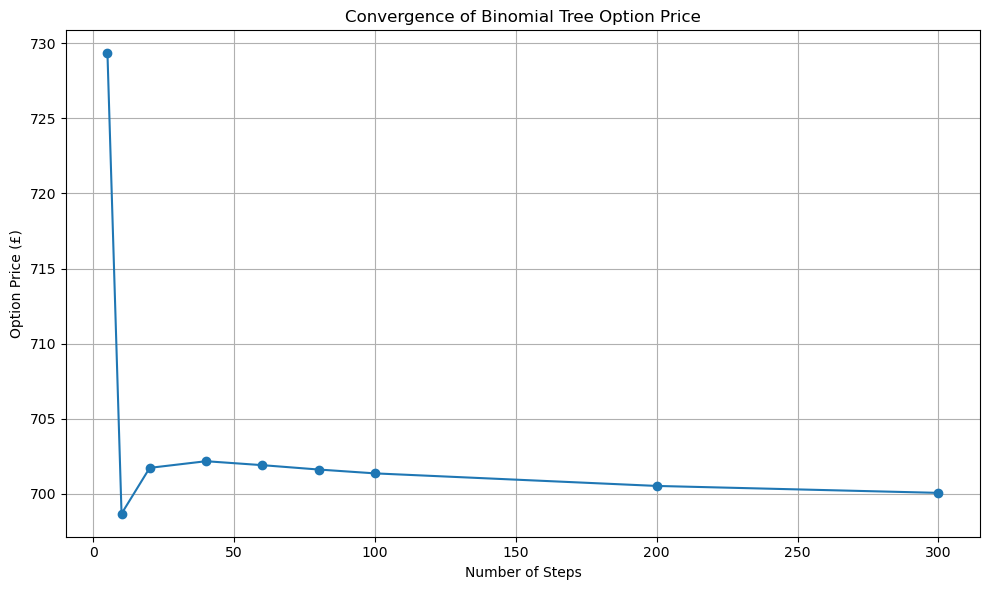

In [23]:
step_sizes = [5, 10, 20, 40, 60, 80, 100, 200, 300] #number of steps from 5 to 300
prices = [binomial_price_func(S, K, T, r, sigma, n) for n in step_sizes]

plt.figure(figsize=(10, 6))
plt.plot(step_sizes, prices, marker='o')
plt.title('Convergence of Binomial Tree Option Price')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price (£)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Parameters
S0 = 10054       # Current stock price
K = 10200        # Strike price
T = 0.5          # Time to maturity
r = 0.045        # Risk-free rate
sigma = 0.2334   # Volatility
n_simulations = 100000  # Number of Monte Carlo paths


In [25]:
# Simulate end-of-period stock prices
np.random.seed(0)  # For reproducibility
Z = np.random.standard_normal(n_simulations)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)


In [26]:
# Calculate payoff for a call option
payoffs = np.maximum(ST - K, 0)

In [27]:
# Discount back to present value
option_price_mc = np.exp(-r * T) * np.mean(payoffs)


In [28]:
# Output result
print("Monte Carlo Estimated European Call Price: £", round(option_price_mc, 2))


Monte Carlo Estimated European Call Price: £ 698.09


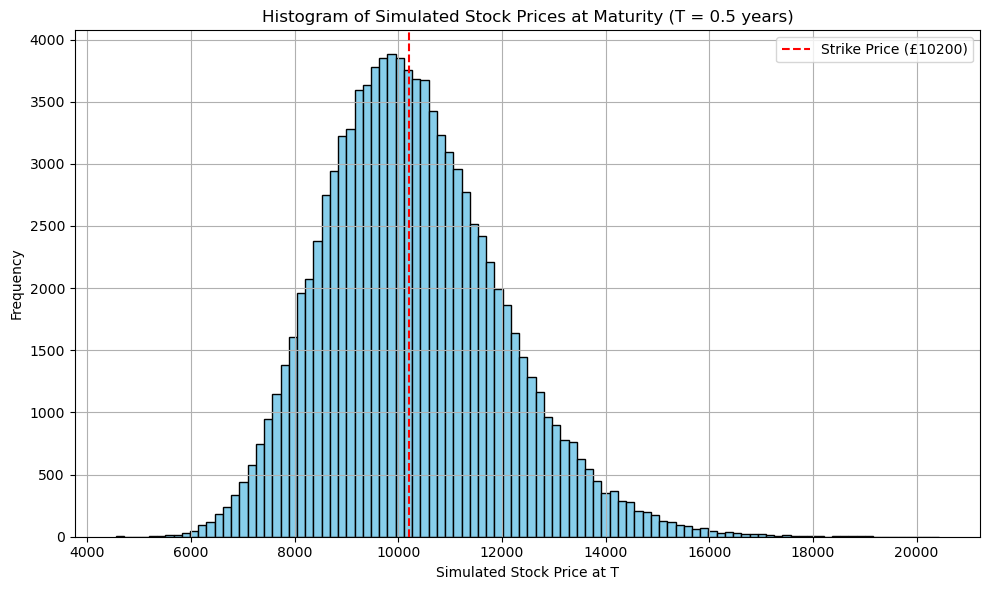

In [29]:
# Plot histogram of simulated prices
plt.figure(figsize=(10, 6))
plt.hist(ST, bins=100, color='skyblue', edgecolor='black')
plt.axvline(x=K, color='red', linestyle='--', label='Strike Price (£10200)')
plt.title('Histogram of Simulated Stock Prices at Maturity (T = 0.5 years)')
plt.xlabel('Simulated Stock Price at T')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
def delta(S, K, T, r, vol, payoff):   #delta Greek calculus
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))  #formula
    if payoff == "call":
        delta = si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  si.norm.cdf(d1, 0.0, 1.0)-1
    
    return delta

In [31]:
delta(10054, 10200, 0.5, 0.045, 0.2334, 'call')

0.5523080528095694

In [32]:
delta(10054, 10200, 0.5, 0.045, 0.2334, 'put')

-0.4476919471904306

In [33]:
S = np.linspace(7000,13000,30)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 10054,  0.5, 0.045, 0.2334, 'call')
    Delta_Put [i] = delta(S[i], 10054,  0.5, 0.045, 0.2334, 'put')

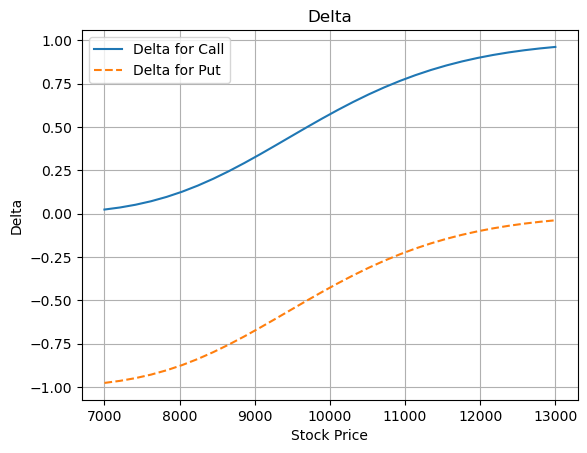

In [34]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [35]:
def gamma(S, K, T, r,  vol, payoff): #gamma calculation
    
    d1 = (np.log(S / K) + (r  + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))

    gamma = si.norm.pdf(d1, 0.0, 1.0) / (vol *  np.sqrt(T) * S) 

    
    return gamma

In [36]:
gamma(10054, 10200, 0.5, 0.045, 0.2334, 'call')

0.00023835851071087855

In [37]:
gamma(10054, 10200, 0.5, 0.045, 0.2334, 'put')

0.00023835851071087855

In [38]:
S = np.linspace(7000,13000,30)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 10054,  0.5, 0.045, 0.2334, 'call')

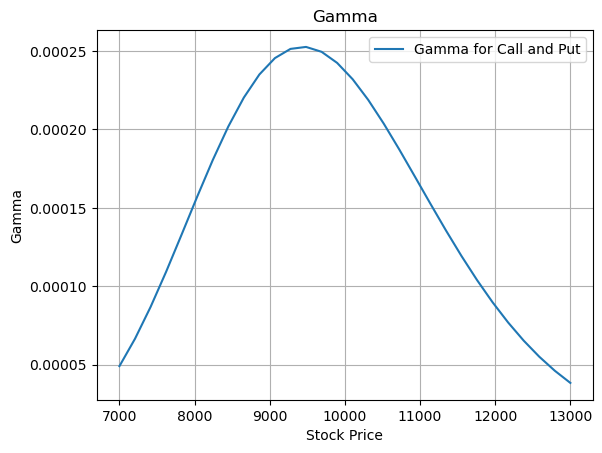

In [39]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [40]:
def theta(S, K, T, r, vol, payoff):  #theta Greek
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    
    if payoff == "call":
        theta = - S * N_d1_prime * vol / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = - S * N_d1_prime * vol / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [41]:
theta(10054, 10200, 0.5, 0.045, 0.2334, 'call')

-874.6556622279018

In [42]:
theta(10054, 10200, 0.5, 0.045, 0.2334, 'put')

-425.8678443561604

In [43]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros(len(T))
Theta_Put = np.zeros(len(T))
for i in range(len(T)):
    Theta_Call [i] = theta(10054, 10200, T[i], 0.045, 0.2234, 'call')
    Theta_Put [i] = theta(10054, 10200, T[i], 0.045, 0.2234, 'put')

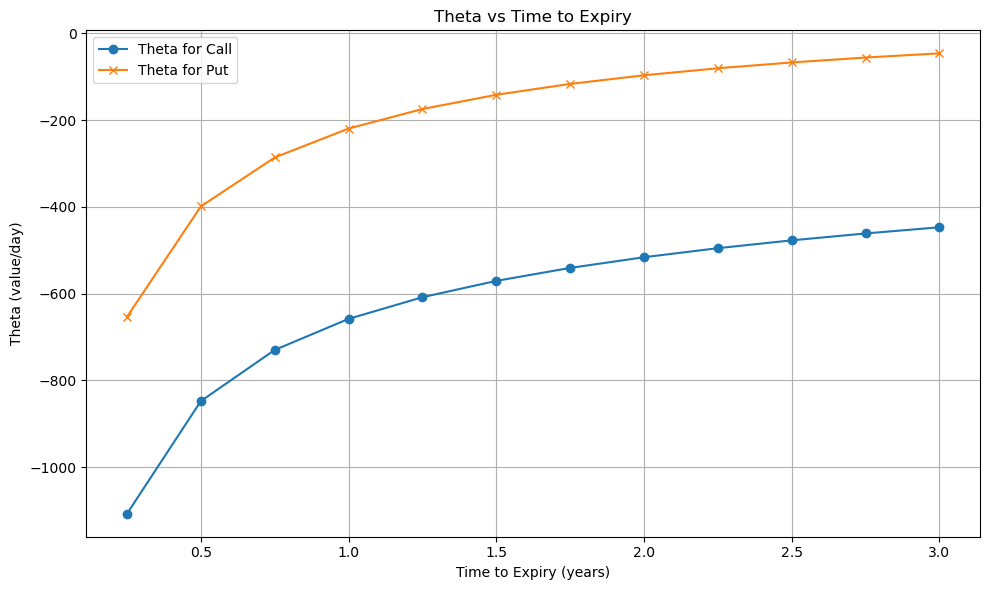

In [44]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(T, Theta_Call, label='Theta for Call', linestyle='-', marker='o')
plt.plot(T, Theta_Put, label='Theta for Put', linestyle='-', marker='x')
plt.grid(True)
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Theta (value/day)')
plt.title('Theta vs Time to Expiry')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
def rho(S, K, T, r, vol, payoff):  #rho Greek
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [46]:
rho(10054, 10200, 0.5, 0.045, 0.2334, 'call')

2426.5479746537726

In [47]:
rho(10054, 10200, 0.5, 0.045, 0.2334, 'put')

-2559.983335032243

In [48]:
r = np.linspace(0,0.09,11)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(10054, 10200, 0.5, r[i], 0.2334, 'call')
    Rho_Put [i] = rho(10054, 10200, 0.5, r[i], 0.2334, 'put')

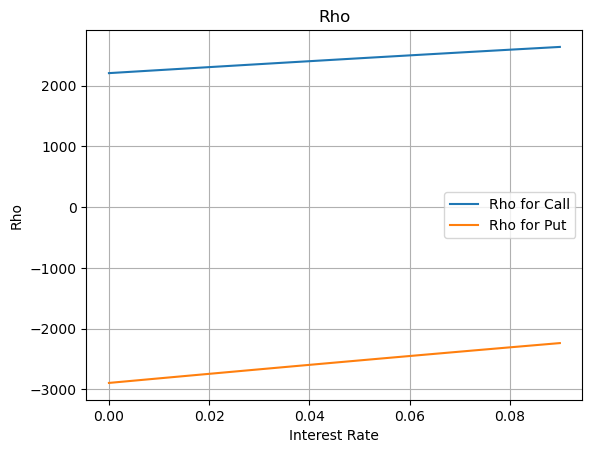

In [49]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

In [50]:
def vega(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    vega = S * np.sqrt(T) * N_d1_prime
    
    return vega

In [51]:
vega(10054, 10200, 0.5, 0.045, 0.2334, 'call')

2811.7666859857

In [52]:
vega(10054, 10200, 0.5, 0.045, 0.2334, 'put')

2811.7666859857

In [53]:
vol = np.linspace(0.075,0.4,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(10054, 10200, 0.5, 0.045, vol[i], 'call')

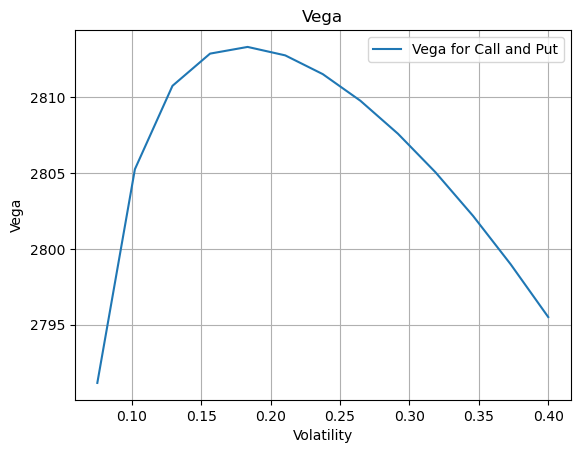

In [54]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [55]:
# Delta hedging
# Parameters
num_options = 5000            # Number of call options sold
delta_per_option = 0.5523     # Delta of one call option (from previous calculation)
share_price_change = 1.00     # Simulated increase in stock price (£1 movement)


In [56]:
# Step 1: Calculate total Delta exposure from short option position
total_delta_exposure = -num_options * delta_per_option

In [57]:
# Step 2: Calculate how many shares to buy to hedge the Delta
shares_to_buy = abs(total_delta_exposure)

In [58]:
# Step 3: Estimate the value change in the option liability and the hedge
option_liability_increase = total_delta_exposure * share_price_change
hedge_gain = shares_to_buy * share_price_change

In [59]:
# Step 4: Calculate the net result (hedge effectiveness)
net_result = hedge_gain + option_liability_increase  # Should be close to 0 if perfectly hedged

In [60]:
# Print results
print("Delta Hedging Simulation")
print("------------------------")
print(f"Total Delta Exposure (short): {total_delta_exposure:.2f}")
print(f"Shares to Buy to Hedge: {round(shares_to_buy)}")
print(f"Option Liability Increase (for £1 move): £{option_liability_increase:.2f}")
print(f"Hedge Gain from Shares: £{hedge_gain:.2f}")
print(f"Net P&L Impact: £{net_result:.2f}")

Delta Hedging Simulation
------------------------
Total Delta Exposure (short): -2761.50
Shares to Buy to Hedge: 2762
Option Liability Increase (for £1 move): £-2761.50
Hedge Gain from Shares: £2761.50
Net P&L Impact: £0.00


In [61]:
import scipy.stats as si  #library import for access to statistical functions

In [62]:
# Black-Scholes formula for a European call or put option
def C_bsm(S, K, T, r, sigma, option='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        return S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2) #returns the discounted expected payoff
    elif option == 'put':
        return K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1) #uses the normal cumulative distribution for probabilities.

In [63]:
# Vega function (sensitivity of option price to volatility)
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * si.norm.pdf(d1) * np.sqrt(T) #N’(d1) - si.norm.pdf(d1)

In [64]:
# Newton-Raphson iteration for implied volatility
def newton_raphson_iv(C_market, S, K, T, r, option='call', initial_vol=0.2, tol=1e-6, max_iter=100):
    sigma = initial_vol                            # Start with an initial guess for volatility
    for i in range(max_iter):                      # Limit the number of iterations to prevent infinite loops
        price = C_bsm(S, K, T, r, sigma, option)   # Compute model price using current volatility
        v = vega(S, K, T, r, sigma)                # Calculate Vega (sensitivity to volatility)
        price_diff = price - C_market              # Difference between model and market prices
        if abs(price_diff) < tol:                  # Check if difference is within tolerance
            return sigma                           # If yes, return current volatility as the result
        sigma -= price_diff / v                    # Update sigma using Newton-Raphson adjustment
    return sigma                                   # Return last guess if convergence not reached

In [65]:
# Input values for AstraZeneca call option
S = 10054       # Current stock price
K = 10200       # Strike price
T = 0.5         # Time to maturity (in years)
r = 0.045       # Risk-free interest rate
C_market = 699.809  # Market-observed option price

In [66]:
# Calculate implied volatility
implied_vol = newton_raphson_iv(C_market, S, K, T, r, option='call')
print("Estimated Implied Volatility:", round(implied_vol, 4)) #Print result

Estimated Implied Volatility: 0.2334


In [67]:
# Load Tesla ticker
tsla = yf.Ticker("TSLA")

In [68]:
# Get current spot price
spot_price = tsla.history(period="1d")["Close"].iloc[-1]
print("Tesla Spot Price:", round(spot_price, 2))

Tesla Spot Price: 221.86


In [69]:
# Get available option expiration dates
print("Available expiration dates:", tsla.options)

Available expiration dates: ('2025-04-11', '2025-04-17', '2025-04-25', '2025-05-02', '2025-05-09', '2025-05-16', '2025-05-23', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')


In [70]:
# Set target expiration date
expiry_date = "2025-06-20"

In [71]:
# Get option chain for the expiration date
opt_chain = tsla.option_chain(expiry_date)
puts = opt_chain.puts

In [191]:
# Display puts around strike prices of interest
puts_filtered = puts[(puts['strike'] == 150) | (puts['strike'] == 350) | (puts['strike'] == 250)]
print(puts_filtered[['contractSymbol', 'strike', 'lastPrice', 'bid', 'ask']])

         contractSymbol  strike  lastPrice  bid  ask
29  TSLA250620P00150000   150.0       9.00  0.0  0.0
49  TSLA250620P00250000   250.0      48.99  0.0  0.0
69  TSLA250620P00350000   350.0     130.00  0.0  0.0


In [207]:
# 1. Black-Scholes formula for European options
def Pbsm(S, K, T, r, sigma, option='put'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        return S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)

In [209]:
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * si.norm.pdf(d1) * np.sqrt(T)

In [221]:
# 3. Newton-Raphson function to estimate IV
def newton_raphson_iv2(p, S, K, T, r, option='put', initial_vol=0.2, tol=1e-6, max_iter=100):
    sigma = initial_vol    # Start with an initial guess for volatility
    min_vega = 1e-8  # Prevent division by extremely small Vega
    for i in range(max_iter):    # Iterate up to a maximum number of steps
        price = Pbsm(S, K, T, r, sigma, option)   # Calculate option price using current sigma
        v = vega(S, K, T, r, sigma)     # Compute Vega (sensitivity of price to volatility)
        if v < min_vega or sigma <= 0:    # Check for small Vega or invalid volatility
            print("Warning: Vega too small or sigma non-positive. Iteration stopped.")
            return np.nan  # or return the current sigma
        diff = price - p    # Compute difference between model price and market price
        if abs(diff) < tol:  # If difference is within tolerance, stop iteration
            return sigma    # Return the converged implied volatility
        sigma -= diff / v  # Update sigma using Newton-Raphson adjustment
    return sigma     # Return final estimate if convergence not reached within max_iter

In [223]:
#Estimating implied volatility for Testla's put options

S = 221.86  # Tesla spot price (example)
r = 0.05    # Risk-free rate (T-bill rate 5%)
expiry_date = datetime(2025, 6, 20)
today= datetime.today()
T = (expiry_date - today).days / 365 # Time to maturity in years
p1 = 9.0  # Put price for option with strike price of 150
p2 = 130.0  #Put price for option with strike price of 350
p3 = 48.99 #Put price for option with strike price of 250



In [225]:
print(T)

0.19452054794520549


In [227]:
# 5. Estimate implied volatilities
iv_250 = newton_raphson_iv(p3, S, 250, T, r, option='put') # Estimate IV for K=250 using put price p3
iv_150 = newton_raphson_iv(p1, S, 150, T, r, option='put') # Estimate IV for K=150 using put price p1
iv_350 = newton_raphson_iv(p2, S, 350, T, r, option='put') # Estimate IV for K=350 using put price p2


/var/folders/th/s5p4vmn93wd1vlnsphpm55w40000gn/T/ipykernel_41624/3113997359.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  sigma -= price_diff / v                    # Update sigma using Newton-Raphson adjustment
/var/folders/th/s5p4vmn93wd1vlnsphpm55w40000gn/T/ipykernel_41624/675007314.py:3: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/th/s5p4vmn93wd1vlnsphpm55w40000gn/T/ipykernel_41624/3924877710.py:2: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [229]:
# 6. Display results
print(f"Implied Volatility for K=150 Put: {iv_150:.4f}")
print(f"Implied Volatility for K=350 Put: {iv_350:.4f}")
print(f"Implied Volatility for K=250 Put: {iv_250:.4f}")

Implied Volatility for K=150 Put: nan
Implied Volatility for K=350 Put: nan
Implied Volatility for K=250 Put: 0.8440


In [232]:
# Download historical data for Tesla
tsla = yf.download('TSLA', period='1y', interval='1d')  # 1 year of daily data
tsla['LogReturn'] = np.log(tsla['Close'] / tsla['Close'].shift(1))
tsla.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [234]:
# Calculate historical volatility (annualised)
historical_vol = tsla['LogReturn'].std() * np.sqrt(252)
print(f"Annual Historical Volatility: {historical_vol:.4f}")

Annual Historical Volatility: 0.6943
